In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.autograd import Function
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import model
import data_loader

In [2]:
BATCH_SIZE = 4
LR = 0.001
INPUT_SIZE = 512 # 输入网络的大小而非图片大小
OUTPUT_SIZE = 324

# root_path = 'D://Data/massachusetts-roads-dataset/'
root_path = '/home/renyan/ossdata/massachusetts-roads-dataset/'
road_path = root_path + "tiff_select_parts/"

DIR_CHECKPOINT = 'checkpoints/'

classes = ['background', 'road']
colormap = [[0 , 0, 0], [255, 255, 255]]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## SGD optimizer

In [4]:
net = model.UNet(n_channels=3, n_classes=1, bilinear=False)
net.load_state_dict(torch.load(DIR_CHECKPOINT + 'sgd_unet_epoch7.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device=device)

In [5]:
def predict_img(net, img, device, threshold = 0.5):
    net.eval()
    net = net.to(device)
    img = img.to(device)
    
    if len(img.shape) == 3:
        img = img.unsqueeze(0)
        
    with torch.no_grad():
        if net.n_classes > 1:
            pred = net(img.unsqueeze(dim=0))
            pred = F.softmax(pred, dim=1).max(dim = 1)[1]
            pred_img = torch.cat((pred, pred, pred))
            pred_img = pred_img.permute((1, 2, 0)) * 255
        else:
            pred = net(img)
            pred = (torch.sigmoid(pred).squeeze(0) > threshold) * 255
            pred = pred.detach().numpy()
            pred_img = np.concatenate([pred, pred, pred]).transpose((1, 2, 0))
            
    return pred_img.cpu()

In [7]:
transform = transforms.Compose([transforms.Resize([512, 512], 0),
                                transforms.ToTensor(),])

In [8]:
test_img_paths = data_loader.get_file_subpaths(road_path + "test/", whole = True)
test_lbl_paths = data_loader.get_file_subpaths(road_path + "test_labels/", whole = True)
print(len(test_img_paths), len(test_lbl_paths))

196 196


In [9]:
img = cv2.imread(test_img_paths[5])
lbl = cv2.imread(test_lbl_paths[5])
img_tensor, label_tensor = transform(Image.fromarray(img)), transform(Image.fromarray(lbl))

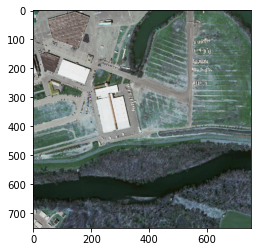

In [10]:
plt.imshow(img);

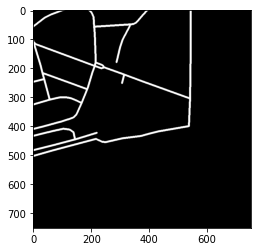

In [11]:
plt.imshow(lbl);

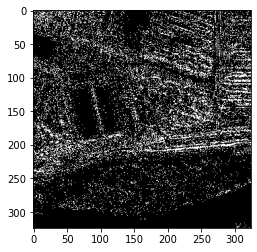

In [16]:
pred = net(img_tensor.unsqueeze(dim=0).cuda())
pred = (torch.sigmoid(pred).squeeze(0) > 0.38) * 255
pred = pred.detach().cpu().numpy()
pred_img = np.concatenate([pred, pred, pred]).transpose((1, 2, 0))
plt.imshow(pred_img);

In [17]:
324 * 324, sum(pred.flatten())/255, sum(pred.flatten())/255/(324 * 324)

(104976, 16771.0, 0.1597603261697912)

## RMSprop optimizer

In [19]:
net = model.UNet(n_channels=3, n_classes=1, bilinear=False)
net.load_state_dict(torch.load(DIR_CHECKPOINT + 'rms_unet_epoch9.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device=device)

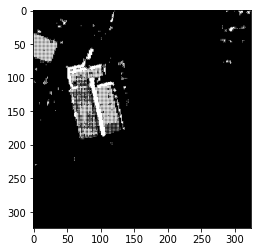

In [24]:
pred = net(img_tensor.unsqueeze(dim=0).cuda())
pred = (torch.sigmoid(pred).squeeze(0) > 0.29) * 255
pred = pred.detach().cpu().numpy()
pred_img = np.concatenate([pred, pred, pred]).transpose((1, 2, 0))
plt.imshow(pred_img);